### Imports

In [1]:
from visualization import get_grid_fakes, get_grid_samples
from samplers import InfSampler
from torch.utils import data
from torch.optim import Adam
from stats import GANStats
from training import train
from torch import optim
import torch

### Setup

In [2]:
# Always reload .py files
%load_ext autoreload
%autoreload 2

# Configuration
environment = 'local'


In [3]:
%% capture

# Install dependencies
if environment == 'local':
    %pip install -r ../requirements.txt
else:
    %pip install ipykernel kaggle matplotlib autopep8 pillow pandas numpy scipy urllib3 scikit-image --find-links https: // download.pytorch.org/whl/cu113/torch_stable.html torch == 1.11.0+cu113 torchaudio == 0.11.0+cu113 torchvision == 0.12.0+cu113 torch_tb_profiler tensorboard


UsageError: Cell magic `%%` not found.


In [4]:
if environment == 'colab':
    from google.colab import files
    import pathlib
    import os

    kaggle_path = '/root/.kaggle/kaggle.json'

    if not os.path.exists(kaggle_path):
        uploaded = files.upload()

        if not 'kaggle.json' in uploaded:
            raise Exception('Kaggle.json not found')

        pathlib.Path('/root/.kaggle').mkdir(exist_ok=True)
        os.rename('./kaggle.json', kaggle_path)

        !chmod 600 / root/.kaggle/kaggle.json

In [5]:
from dataset import MonetDataset, download_dataset
import torchvision
import torch


# Define custom paths
data_dir = os.path.join('..', 'data')

# Download the dataset
download_dataset(data_dir)

# Define preprocessing step
process = torchvision.transforms.ConvertImageDtype(torch.float)

# Load datasets
monet_dataset = MonetDataset(monet=True, data_dir=data_dir, transforms=process)
photo_dataset = MonetDataset(monet=False, data_dir=data_dir, transforms=process)

Dataset already exists at ../data


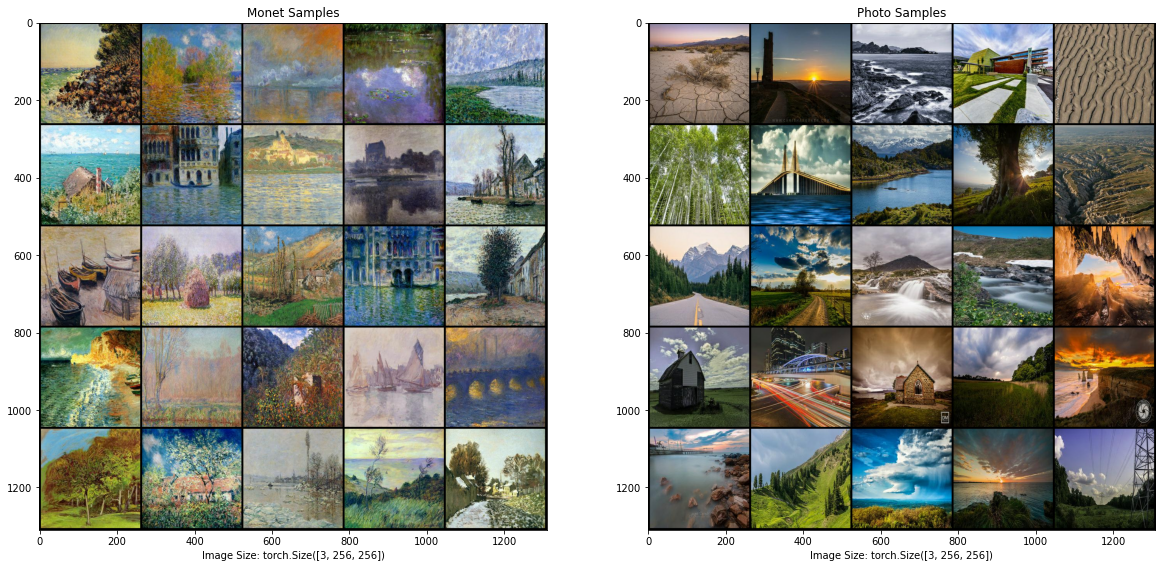

In [6]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Create a dataloader for previewing samples
batch_size = 25
row_count = int(np.sqrt(batch_size))
monet_preview_loader = DataLoader(monet_dataset, batch_size, shuffle=True)
photo_preview_loader = DataLoader(photo_dataset, batch_size, shuffle=True)

# Get a batch of images
monet_preview_imgs = next(iter(monet_preview_loader))
photo_preview_imgs = next(iter(photo_preview_loader))

# Make a grid (image) from a couple of samples from the training dataset
monet_preview_grid = make_grid(
    monet_preview_imgs, nrow=row_count, padding=5, normalize=True)
photo_preview_grid = make_grid(
    photo_preview_imgs, nrow=row_count, padding=5, normalize=True)

# Preview the samples
fig, (monet_axis, photo_axis) = plt.subplots(1, 2, figsize=(20, 20))
monet_axis.set_title('Monet Samples')
monet_axis.set_xlabel(f'Image Size: {monet_preview_imgs[0].size()}')
monet_axis.imshow(monet_preview_grid.permute(1, 2, 0))
photo_axis.set_title('Photo Samples')
photo_axis.set_xlabel(f'Image Size: {photo_preview_imgs[0].size()}')
photo_axis.imshow(photo_preview_grid.permute(1, 2, 0))
plt.show()


### Training

Preparing the Datasets for Training and Validation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


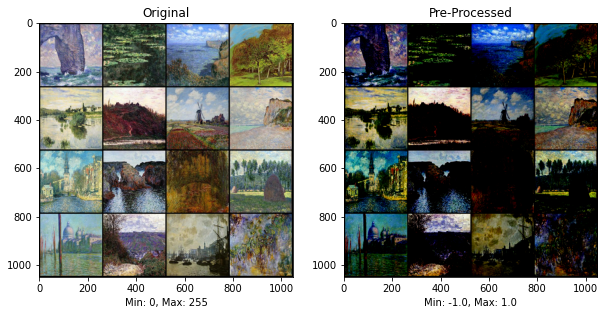

In [7]:
# Custom batch_size
process_workers = 0
batch_size = 16

# Define the pre-processing pipeline
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ConvertImageDtype(dtype=torch.float),
    torchvision.transforms.Normalize(
        [0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5]
    ),
])

# Create the dataset for training
monet_dataset = MonetDataset(
    transforms=preprocess,
    data_dir=data_dir,
    monet=True,
)

# Prepare dataloader - sample random batches without stopping
random_sampler = data.RandomSampler(monet_dataset, replacement=False)
batch_sampler = data.BatchSampler(random_sampler, batch_size=batch_size,drop_last=True)
inf_sampler = InfSampler(batch_sampler)

# Create the dataloader using the batch sampler
data_loader = DataLoader(monet_dataset, batch_sampler=inf_sampler,
                        #  prefetch_factor=batch_size // 8,
                         num_workers=process_workers)

# Show before and after samples
fig, (orig, proc) = plt.subplots(1, 2, figsize=(10, 5))

# Get samples without preprocessing
monet_dataset.transforms = None
grid_orig = get_grid_samples(monet_dataset, n_samples=16, normalize=False)

# Get samples with preprocessing
monet_dataset.transforms = preprocess
grid_proc = get_grid_samples(monet_dataset, n_samples=16, normalize=False)

# Add meta-data
orig.set_xlabel(f'Min: {grid_orig.min()}, Max: {grid_orig.max()}')
proc.set_xlabel(f'Min: {grid_proc.min()}, Max: {grid_proc.max()}')
proc.set_title('Pre-Processed')
orig.set_title('Original')

# Plot the images
orig.imshow(grid_orig)
proc.imshow(grid_proc)
plt.show()

GAN Architecture Initialization

In [8]:
from model import GAN, Discriminator, Generator
from torch import nn

# Use available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Noise tensor dimension
noise_dim = 100

# Define GAN networks
g = Generator(
    in_dim=torch.Size((noise_dim,)),
    hidden_dim=torch.Size((512, 4, 4)),
    out_dim=torch.Size((3, 256, 256)),
    activ_fun=nn.LeakyReLU(inplace=True),
    bias=True,
)

d = Discriminator(
    in_dim=torch.Size((3, 256, 256)),
    hidden_dim=torch.Size((256,)),
    out_dim=torch.Size((1, 1)),
    activ_fun=nn.LeakyReLU(inplace=True),
    bias=True,
)

# Bundle the networks into a GAN
gan = GAN(g, d).to(device)

Training Parameter Settings

In [9]:
# The total amount of epochs to train for
num_epochs = 2
pretraining = 5
epoch_size = 10

# The number of steps the Discriminator trains per-cycle
d_steps = 1

# Create optimizers for each network
optim_D = Adam(gan.D.parameters(), lr=1e-3)
optim_G = Adam(gan.G.parameters(), lr=2e-4)
optims = [optim_D, optim_G]

# Clear the gradients of the networks
optim_D.zero_grad()
optim_G.zero_grad()

# Define loss function
loss_fn = torch.nn.BCELoss()

Training

Epoch 1, D_prob_real=0.38, D_prob_fake1=0.37, D_prob_fake2=0.36, D_loss=1.4, G_loss=1.0


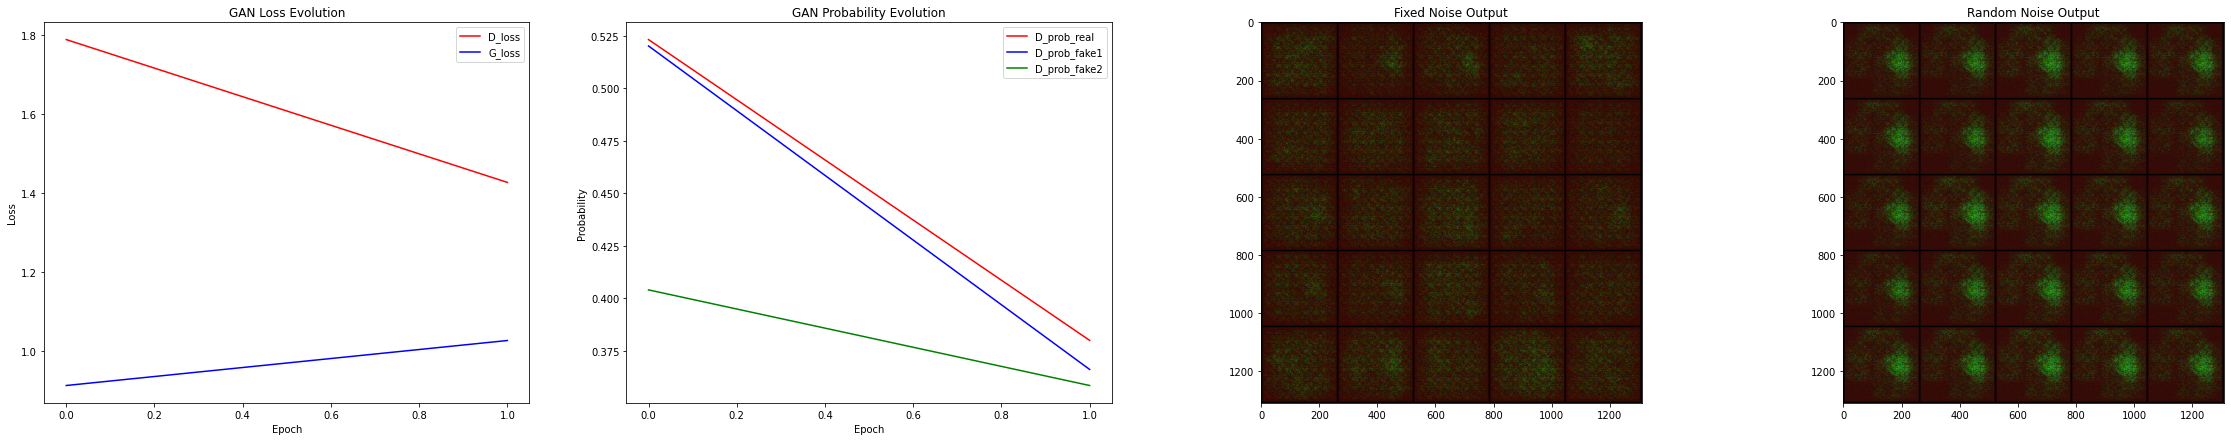

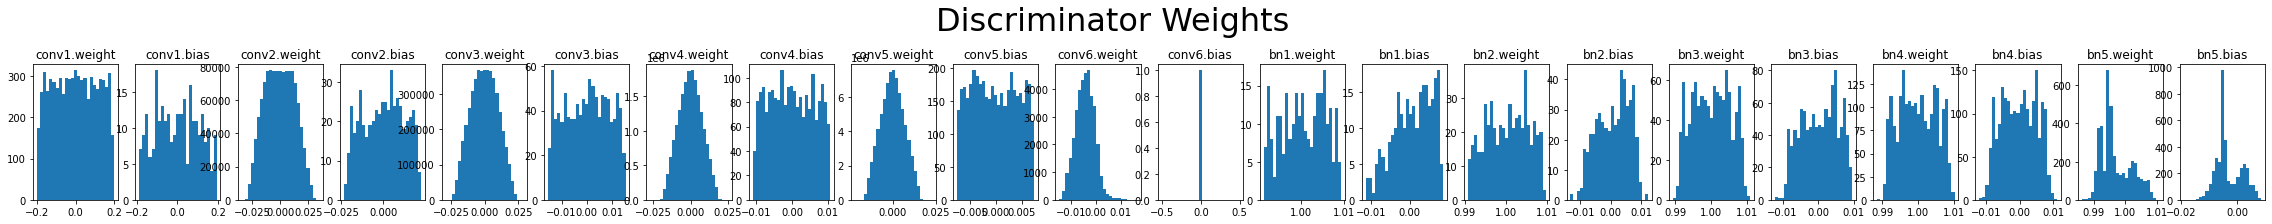

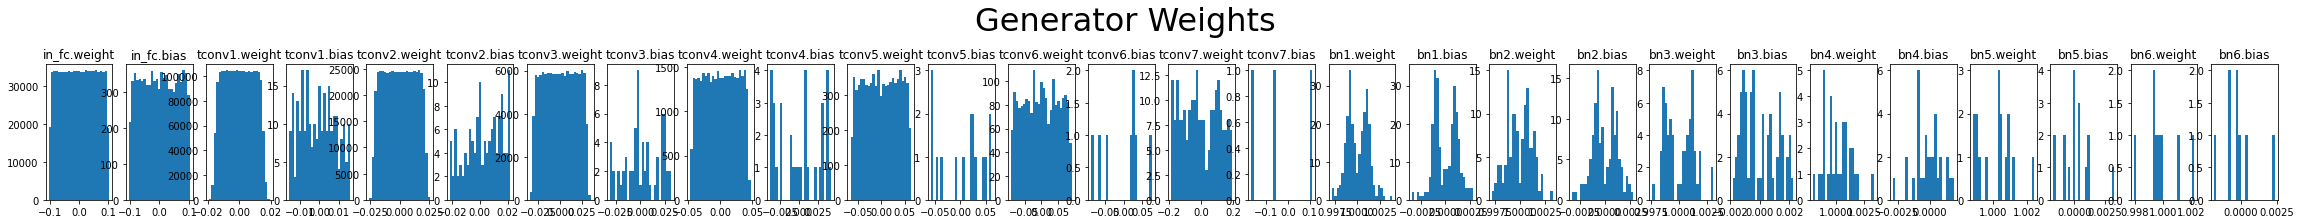

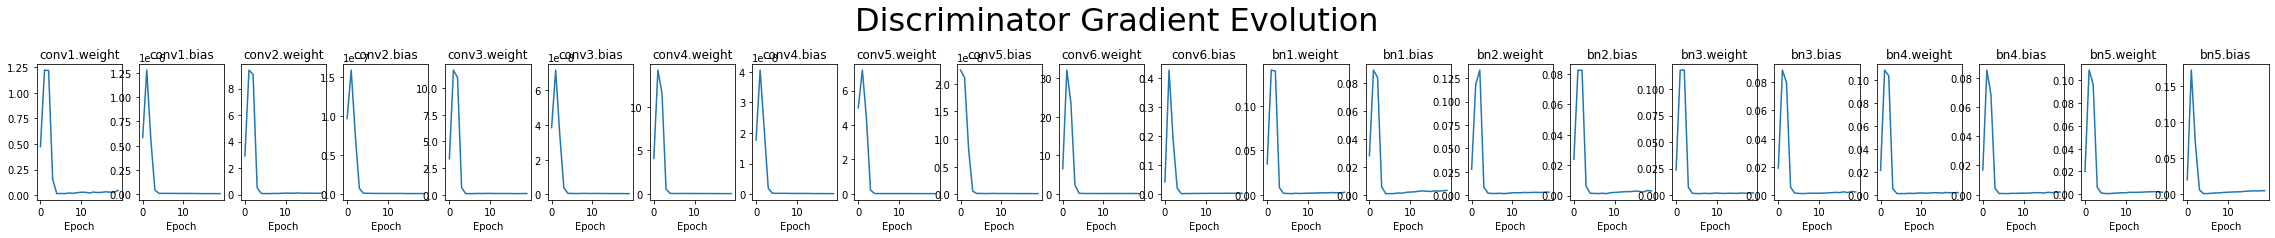

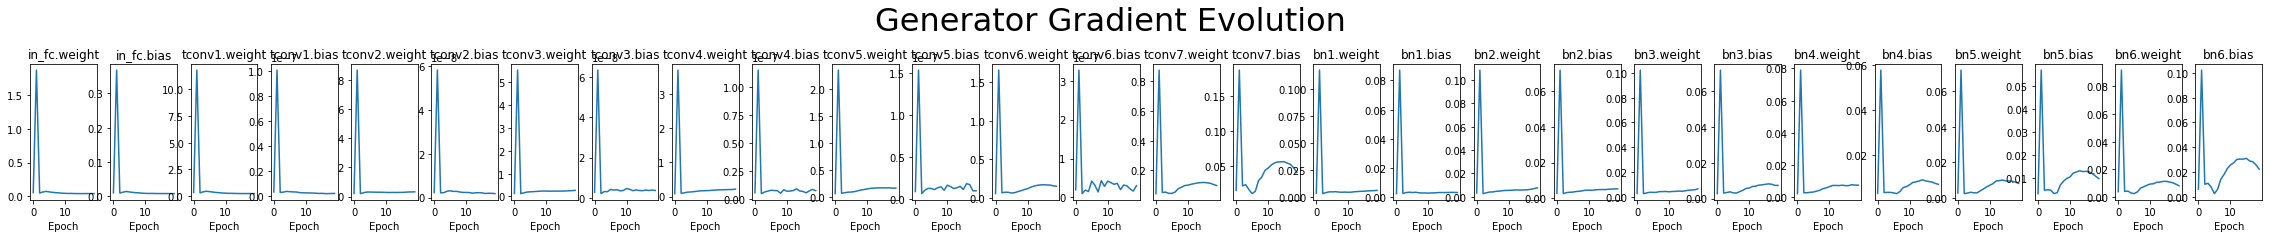

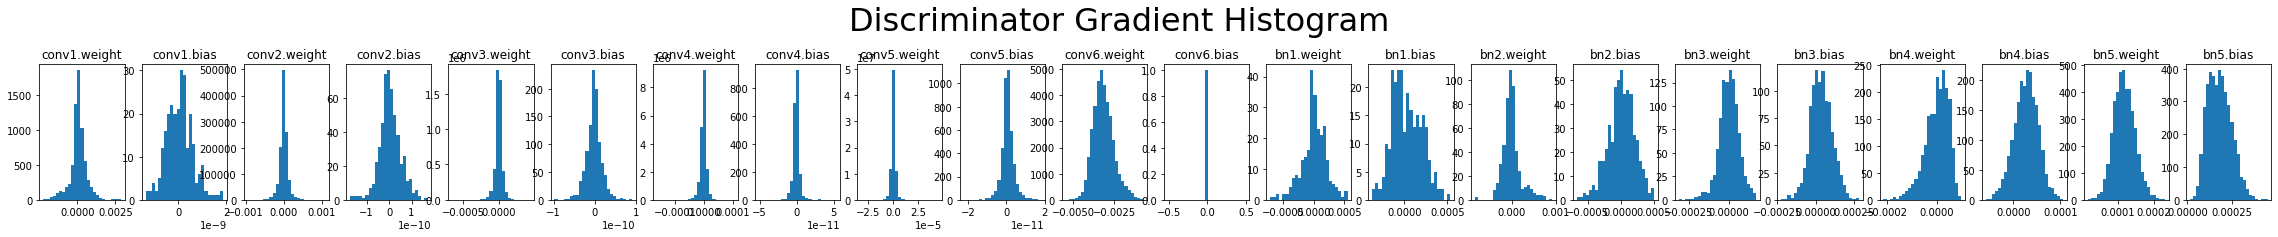

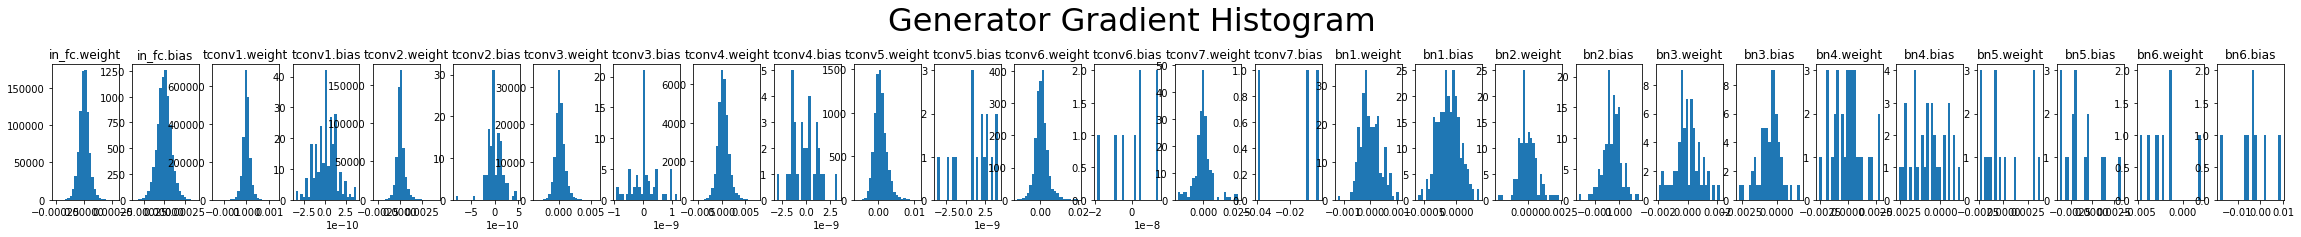

In [10]:
# Evaluate the same noise over time
fixed_noise = torch.randn((25, noise_dim), device=device)

# Train the GAN
# with torch.autograd.detect_anomaly():
train(num_epochs=num_epochs, epoch_size=epoch_size, d_steps=d_steps, gan=gan,
      loss_fn=loss_fn, device=device, fixed_noise=fixed_noise,
      data_loader=data_loader, optims=optims, pretraining=None)